# Sun gp-test

In [12]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk


import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

## Import pitchfork

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## save observed/published parameters

In [3]:
#parameters for star, [value,unc], NaN for not found/published
#1 : Lyttle
#2 : Asplund 2020
#3 : 
#4 : 

star_name = 'Sun'

star_dict={}

star_dict['initial_mass']=[1, 0.001] #1
star_dict['initial_Zinit']= [0.0154, 0.002] #2
star_dict['initial_Yinit']= [0.2766, 0.01] #2
star_dict['initial_MLT']= [1.92, 0.09] #2
star_dict['star_age']=[4.6, 0.1] #1

star_dict['calc_effective_T']=[5777, 20]  #1
star_dict['radius']=[1, 0.001] #1
star_dict['luminosity']=[1, 0.01] #1
star_dict['star_feh']=[0, 0.01] #1

#############
star_dict['nu_0_6']= [972.615, 0.002]
star_dict['nu_0_7']= [1117.993, 0.004]
star_dict['nu_0_8']= [1263.198, 0.005]
star_dict['nu_0_9']= [1407.472, 0.006]
star_dict['nu_0_10']= [1548.336, 0.007]
star_dict['nu_0_11']= [1686.594, 0.012]
star_dict['nu_0_12']= [1822.202, 0.012]
star_dict['nu_0_13']= [1957.452, 0.012]
star_dict['nu_0_14']= [2093.518, 0.013]
star_dict['nu_0_15']= [2228.749, 0.014]
star_dict['nu_0_16']= [2362.788, 0.016]
star_dict['nu_0_17']= [2496.180, 0.017]
star_dict['nu_0_18']= [2629.668, 0.015]
star_dict['nu_0_19']= [2764.142, 0.015]
star_dict['nu_0_20']= [2899.022, 0.013]
star_dict['nu_0_21']= [3033.754, 0.014]
star_dict['nu_0_22']= [3168.618, 0.017]
star_dict['nu_0_23']= [3303.520, 0.021]
star_dict['nu_0_24']= [3438.992, 0.030]
star_dict['nu_0_25']= [3574.893, 0.048]
star_dict['nu_0_26']= [3710.717, 0.088]
star_dict['nu_0_27']= [3846.993, 0.177]
star_dict['nu_0_28']= [3984.214, 0.323]
star_dict['nu_0_29']= [np.nan, np.nan]
star_dict['nu_0_30']= [np.nan, np.nan]
star_dict['nu_0_31']= [np.nan, np.nan]
star_dict['nu_0_32']= [np.nan, np.nan]
star_dict['nu_0_33']= [np.nan, np.nan]
star_dict['nu_0_34']= [np.nan, np.nan]
star_dict['nu_0_35']= [np.nan, np.nan]
star_dict['nu_0_36']= [np.nan, np.nan]
star_dict['nu_0_37']= [np.nan, np.nan]
star_dict['nu_0_38']= [np.nan, np.nan]
star_dict['nu_0_39']= [np.nan, np.nan]
star_dict['nu_0_40']= [np.nan, np.nan]

##############

star_dict['dnu'] = [135.1, 0.2] #1
star_dict['nu_max'] = [3141, 12]

with open(f'stars/{star_name}/{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict

{'initial_mass': [1, 0.001],
 'initial_Zinit': [0.0154, 0.002],
 'initial_Yinit': [0.2766, 0.01],
 'initial_MLT': [1.92, 0.09],
 'star_age': [4.6, 0.1],
 'calc_effective_T': [5777, 20],
 'radius': [1, 0.001],
 'luminosity': [1, 0.01],
 'star_feh': [0, 0.01],
 'nu_0_6': [972.615, 0.002],
 'nu_0_7': [1117.993, 0.004],
 'nu_0_8': [1263.198, 0.005],
 'nu_0_9': [1407.472, 0.006],
 'nu_0_10': [1548.336, 0.007],
 'nu_0_11': [1686.594, 0.012],
 'nu_0_12': [1822.202, 0.012],
 'nu_0_13': [1957.452, 0.012],
 'nu_0_14': [2093.518, 0.013],
 'nu_0_15': [2228.749, 0.014],
 'nu_0_16': [2362.788, 0.016],
 'nu_0_17': [2496.18, 0.017],
 'nu_0_18': [2629.668, 0.015],
 'nu_0_19': [2764.142, 0.015],
 'nu_0_20': [2899.022, 0.013],
 'nu_0_21': [3033.754, 0.014],
 'nu_0_22': [3168.618, 0.017],
 'nu_0_23': [3303.52, 0.021],
 'nu_0_24': [3438.992, 0.03],
 'nu_0_25': [3574.893, 0.048],
 'nu_0_26': [3710.717, 0.088],
 'nu_0_27': [3846.993, 0.177],
 'nu_0_28': [3984.214, 0.323],
 'nu_0_29': [nan, nan],
 'nu_0_30': 

## define priors

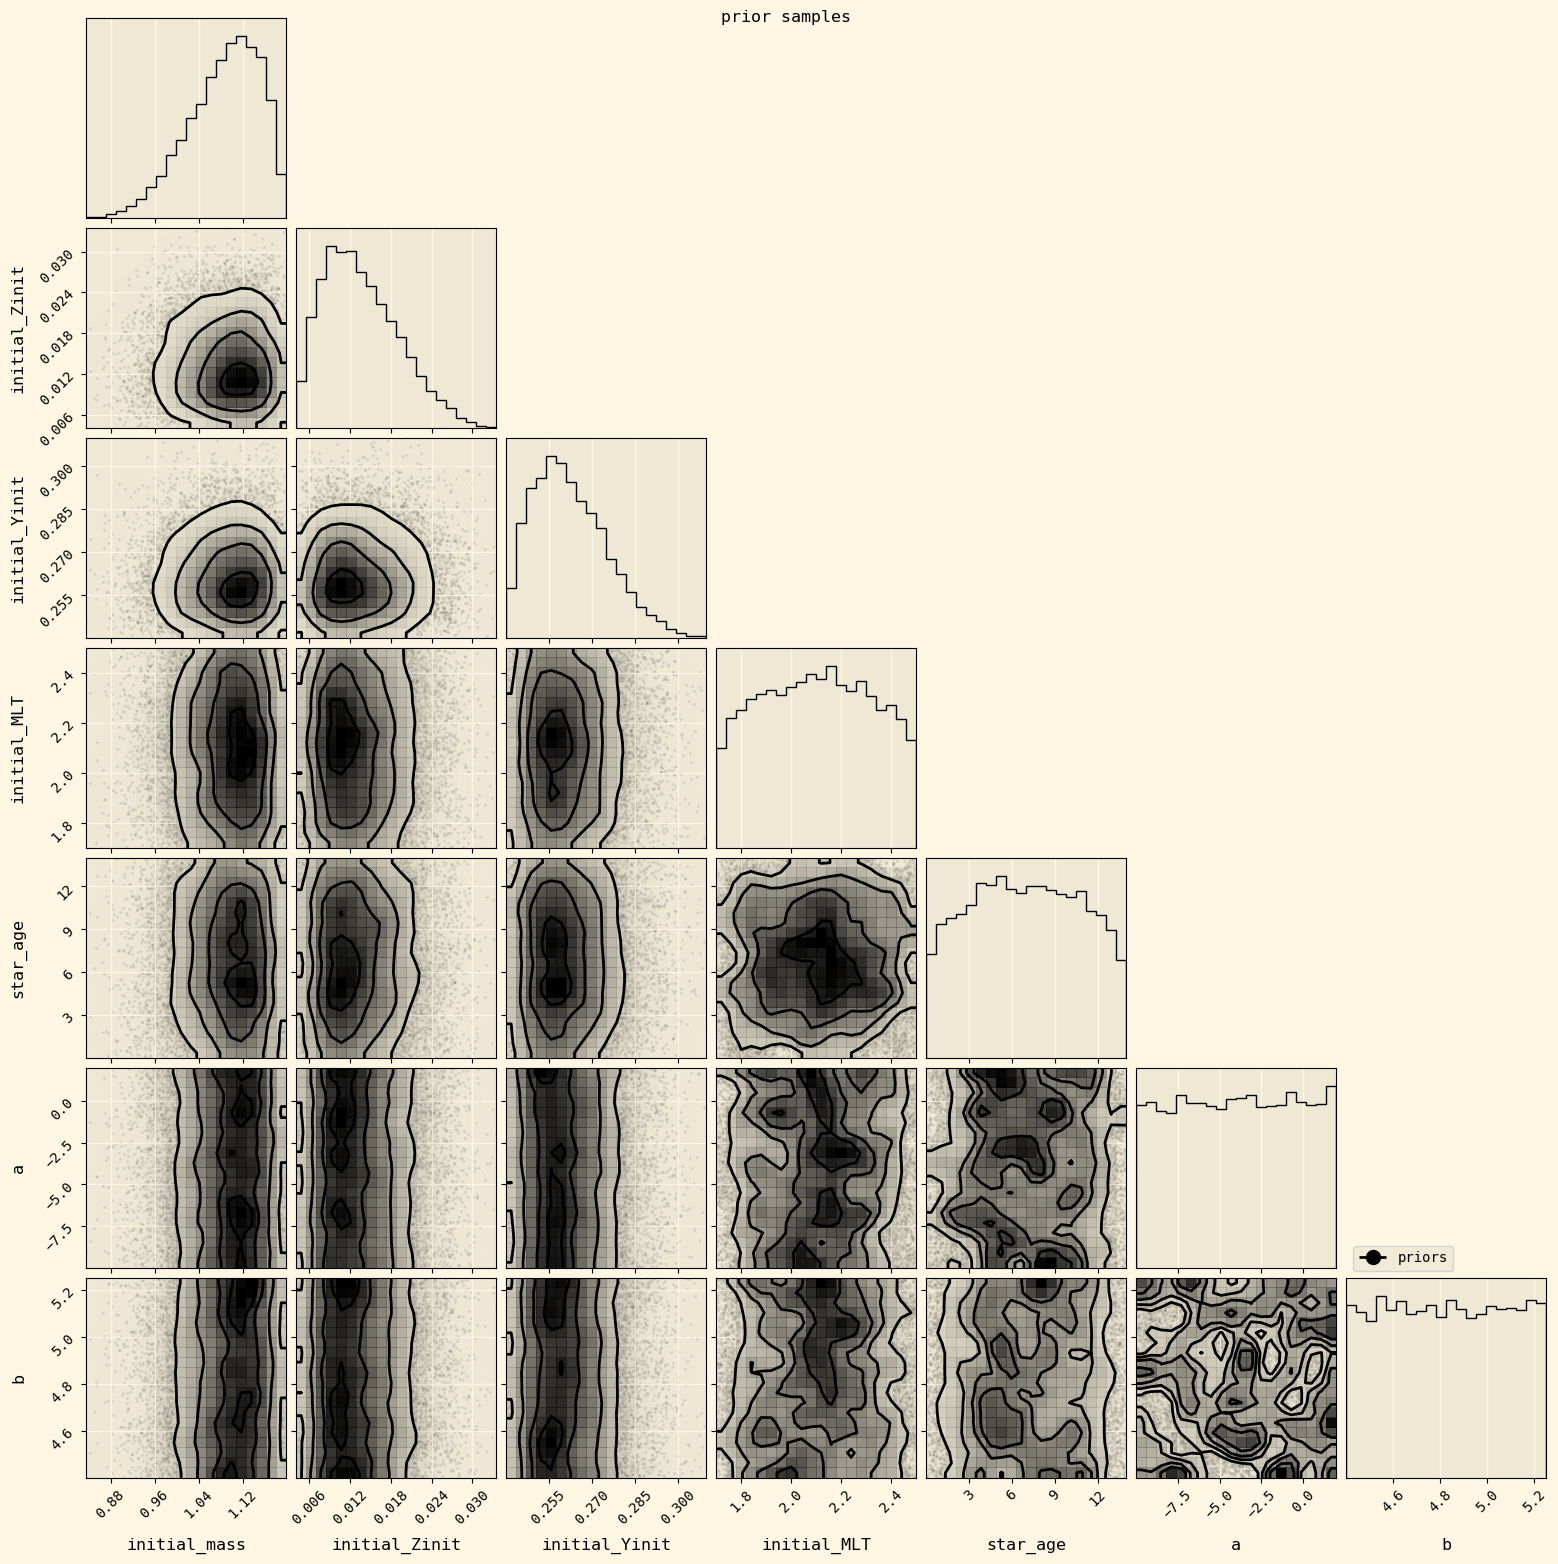

In [4]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## pre-sampling step
define relevant covariance matrices for likelihood, inputs and outputs etc

In [ ]:
L = [1,3,5,7,9,11,13,15,17]
S = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75]

import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)


for s in S:
    for l in L:
        path = f'stars/{star_name}/'
        
        star_json = path + f'{star_name}.json'
        
        star_df = pd.read_json(star_json).dropna(axis=1)
        
        star_vals_df = star_df.iloc[[0]]
        
        star_uncs_df = star_df.iloc[[1]]
        
        nu_max = star_df["nu_max"].values[0]
        
        ### obs matrix
        star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
        
        star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
        
        sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))
        
        ### nn matrix
        with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
             sigma_nn = pickle.load(fp)
        
        n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
        n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
        
        sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
        sigma_nn_mask[:3] = True
        sigma_nn_mask[n_min-3:n_max-2] = True
        
        sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]
        
        ### gp matrix
        obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()
        
        dnu = star_df['dnu'].values[0]
        
        kernel = s*kernels.ExpSquared(scale=l*dnu) ##### changed to 20 dnu instead of 5, 5 muHz too
        
        gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)
        
        gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()
        
        gp_cov_padded = np.pad(gp_cov, (3,0))
        
        # add covariance matrices
        sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded
        
        sigma_inv = np.linalg.inv(sigma)
        
        _, log_sigma_det = np.linalg.slogdet(sigma)

        ndraw_min=2**16
        ndraw_max=2**19
        min_num_live_points = 256
        
        print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
        print(f"current S : {s}")
        print(f"current L : {l}")
        sampler = ultra_ns_vector_surface(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
        results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=0.1*min_num_live_points, frac_remain=.33, max_ncalls=5e6, viz_callback=False)
        results['gp_lengthscale'] = l
        results['gp_variance'] = s
        with open(path+f'gp-test/samples_s{s}_l{l}.pkl', 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
        sampler.cleanup()
        del results


|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
current S : 1
current L : 1


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |ff=3.3445% N=256   
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
current S : 1
current L : 3


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |.1546% N=256   
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
current S : 1
current L : 5


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (1/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |.4235% N=256   
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
current S : 1
current L : 7


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


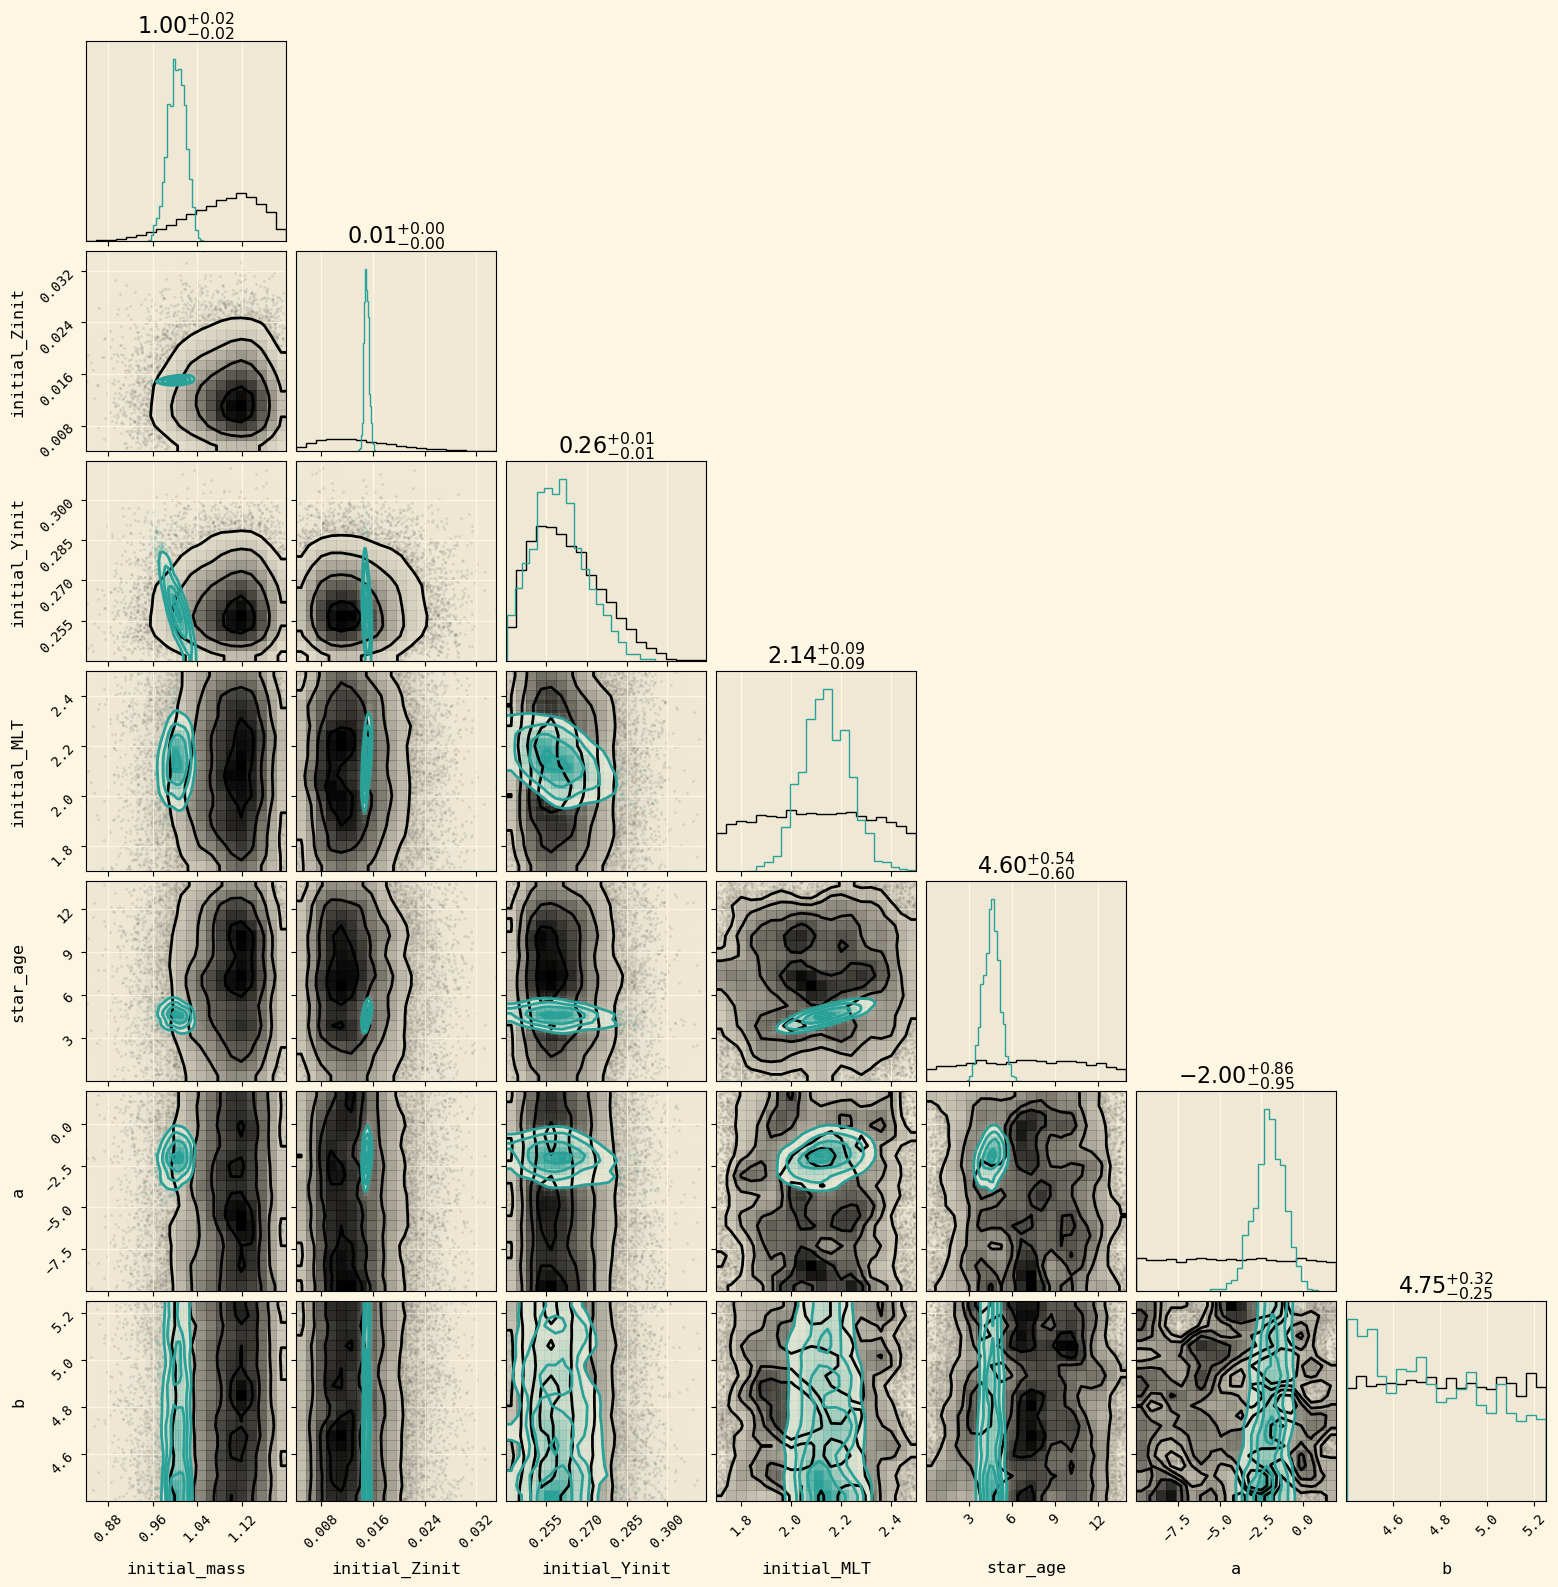

In [8]:
def inspect_star(path, s, l):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    
    path = f'stars/{star_name}/'
    
    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

    with open(path+f'gp-test/samples_s{s}_l{l}.pkl', 'rb') as fp:
     samples = pickle.load(fp)
        
    #corner.corner(samples['samples'], fig=figure, color=colors[1], truths = published_inps, hist_kwargs={'density':True}, smooth=True,show_titles=True);
    corner.corner(samples['samples'], fig=figure, color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.show()

s = 3
l = 7
inspect_star(path, s,l)

# Posterior Predictive

0       0.996271
1       1.007475
2       1.006696
3       1.005216
4       1.008895
          ...   
4320    0.996463
4321    1.005338
4322    1.007023
4323    1.012427
4324    1.006135
Name: radius, Length: 4325, dtype: float64


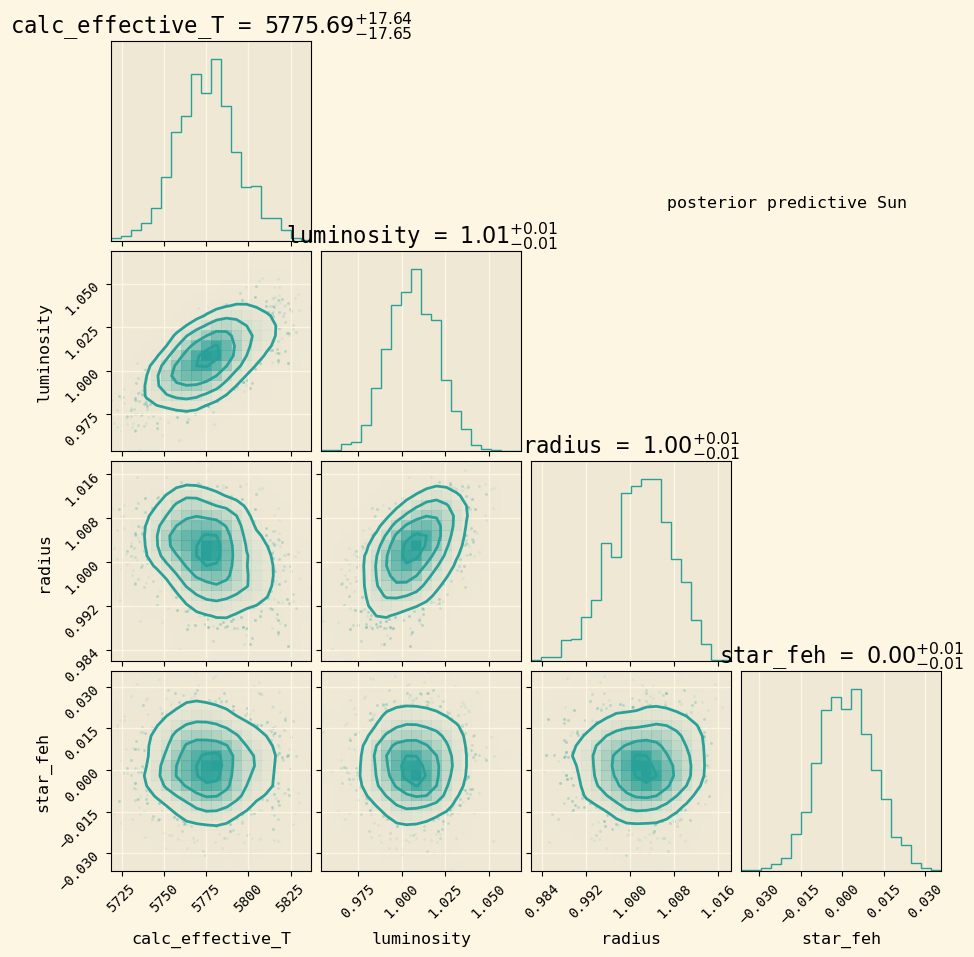

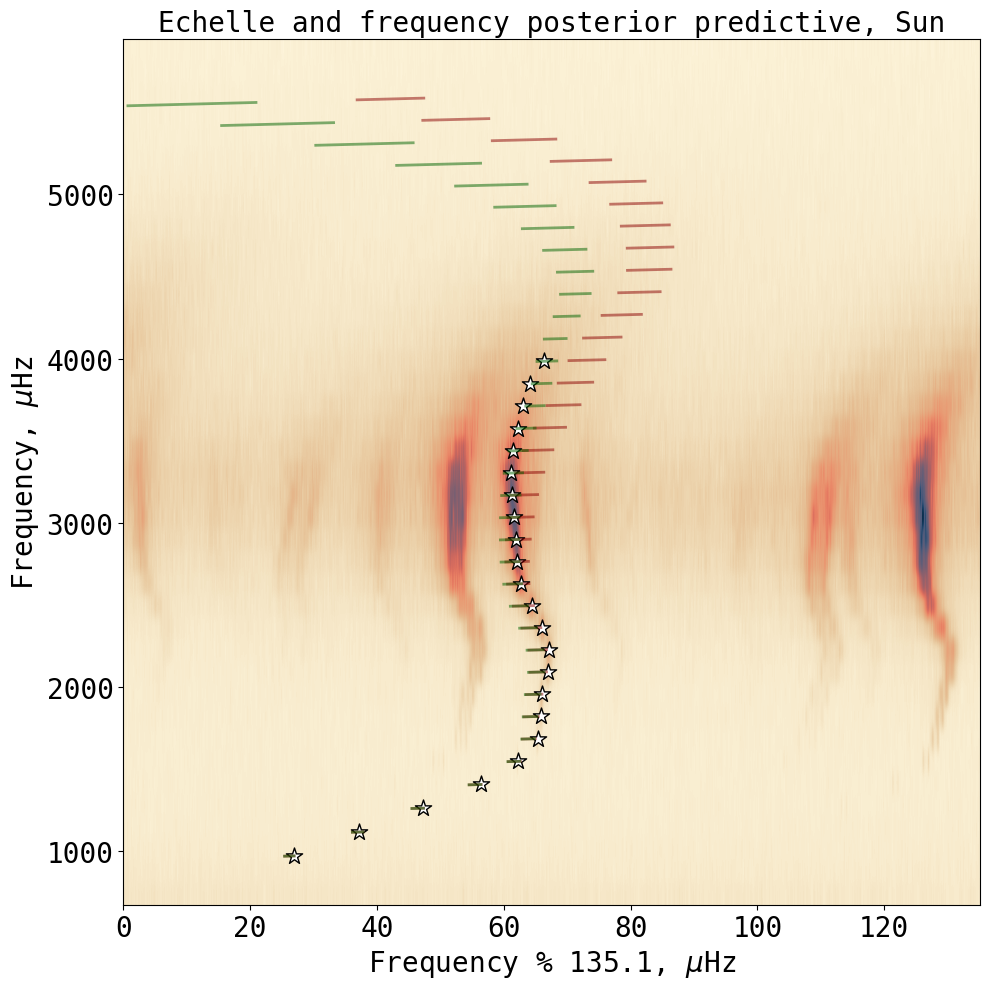

In [14]:
def posterior_pred(pitchfork, star_name, s, l):

    path = f'stars/{star_name}/'

    with open(path+f'gp-test/samples_s{s}_l{l}.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)

    preds_df['radius'] = (np.sqrt((preds_df['luminosity']*astropy.constants.L_sun)/(4*np.pi*constants.sigma*(preds_df['calc_effective_T']**4))))/astropy.constants.R_sun

    print(preds_df['radius'])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "radius", "star_feh"]], labels = ["calc_effective_T", "luminosity", "radius", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    #print(len(pred_freqs))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    from echelle import plot_echelle

    spectrum = np.load('stars/Sun/solar-data.npy', allow_pickle=True).item()
    freq = spectrum['Frequency']
    power = spectrum['Power']
    
    fig, ax = plt.subplots(figsize=[10, 10])
    plot_echelle(freq,power,dnu, scale = 'sqrt', fmin=800, fmax=6000, interpolation='bicubic', smooth=True, ax=ax, cmap=cm.lipari_r)

    echelle_c = 'darkred' #colors[4]
    echelle_a = 0.5
    
    pred_freqs_array = preds_df[[f"nu_0_{i}" for i in range(6, 41)]]
    for n in range(6,41):
        pred_freqs = pred_freqs_array[f'nu_0_{n}'].values
        pred_freqs_mean = np.mean(pred_freqs)
        pred_freqs_std = np.std(pred_freqs)
        
        plot_lower_y = pred_freqs_mean - pred_freqs_std
        plot_lower_x = plot_lower_y%dnu

        plot_upper_y = pred_freqs_mean + pred_freqs_std
        plot_upper_x = plot_upper_y%dnu

        if plot_lower_x < plot_upper_x:
            ax.plot([plot_lower_x, plot_upper_x], [plot_lower_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
        else:
            ax.plot([0, plot_upper_x], [plot_upper_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
            ax.plot([plot_lower_x, dnu], [plot_lower_y, plot_lower_y], color=echelle_c, alpha=echelle_a)

    
    corrected_array = surf_corr(pred_freqs_array, nu_max, np.tile(a_samples,(35,1)).T,np.tile(b_samples,(35,1)).T)
    echelle_c = 'darkgreen' #colors[2]
    echelle_a = 0.5
    for n in range(6,41):
        corrected_freqs = corrected_array[f'nu_0_{n}'].values
        corrected_freqs_mean = np.mean(corrected_freqs)
        corrected_freqs_std = np.std(corrected_freqs)
        
        plot_lower_y = corrected_freqs_mean - corrected_freqs_std
        plot_lower_x = plot_lower_y%dnu

        plot_upper_y = corrected_freqs_mean + corrected_freqs_std
        plot_upper_x = plot_upper_y%dnu

        if plot_lower_x < plot_upper_x:
            ax.plot([plot_lower_x, plot_upper_x], [plot_lower_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
        else:
            ax.plot([0, plot_upper_x], [plot_upper_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
            ax.plot([plot_lower_x, dnu], [plot_lower_y, plot_lower_y], color=echelle_c, alpha=echelle_a)

    obs_freqs = star_vals_df[[f'nu_0_{n}' for n in range(n_min, n_max+1)]].values
    ax.scatter(obs_freqs%dnu, obs_freqs, color='white', marker='*',s=150, facecolor='white', edgecolor='black')

    plt.title(f'Echelle and frequency posterior predictive, {star_name}', fontsize=20)
    #plt.legend()
    tick_fontsize=20
    plt.yticks(fontsize=tick_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    label_fontsize = 20
    plt.ylabel(rf'Frequency, $\mu$Hz' ,fontsize=label_fontsize)
    plt.xlabel(rf'Frequency % {dnu}, $\mu$Hz', fontsize=label_fontsize)
    plt.grid(visible=None)
    plt.xlim(xmin=0)
    
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    fig.patch.set_alpha(0.0)
    #plt.savefig('figs/xmas_echelle.png', bbox_inches='tight')

s=3
l=7
posterior_pred(pitchfork, star_name, s,l)